In [1]:
import fitsio
from fitsio import FITS, FITSHDR
from astropy import wcs
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

In [2]:
git_path = os.environ['GIT_REPO_LOC']
data_path = os.path.join(git_path, 'DECamSurvey.jl/dat')
image_filename = os.path.join(data_path, 'c4d_160302_094418_oki_z_v1.fits')
mask_filename = os.path.join(data_path, 'c4d_160302_094418_ood_z_v1.fits')
dr3_object = fitsio.read_header(image_filename)['OBJECT']

Good pixel proportion:
0.974422192838


<IPython.core.display.Javascript object>


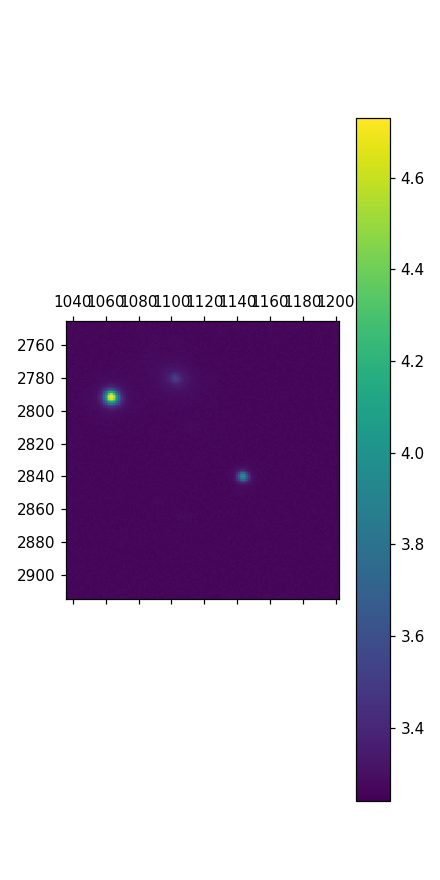

In [21]:
# Load an image.
image_index = 3
image = fitsio.read(image_filename, ext=image_index)
image_mask = fitsio.read(mask_filename, ext=image_index)
header = fitsio.read_header(image_filename, ext=image_index)
im_wcs = wcs.WCS(header)

print 'Good pixel proportion:'
print np.sum(image_mask == 0) / float(np.prod(image_mask.shape))
image[image_mask == 1] = float('nan')
plt.matshow(np.log10(image), interpolation="nearest")
plt.colorbar()

In [15]:
# Load the catalog.

def get_brick_names_for_image(header, brick_filename):
    # First select the bricks that overlap with the image.
    ra_corners = [ header['COR%dRA1' % (i + 1)] for i in range(4)]
    dec_corners = [ header['COR%dDEC1' % (i + 1)] for i in range(4)]
    brick_select = \
      'ra2 > {ramin} && ra1 < {ramax} && dec2 > {decmin} && dec1 < {decmax}'.format(
          ramin=np.min(ra_corners), ramax=np.max(ra_corners),
          decmin=np.min(dec_corners), decmax=np.max(dec_corners))

    brick_fits = fitsio.FITS(brick_filename)
    keep_rows = brick_fits[1].where(brick_select) 
    bricks = brick_fits[1]['brickname'][keep_rows]
    brick_fits.close()
    
    return bricks

brick_filename = os.path.join(data_path, 'survey-bricks.fits')
bricks = get_brick_names_for_image(header, brick_filename)
print bricks


['1984p110' '1986p110' '1984p112' '1987p112']


In [70]:
def load_catalog(tractor_filename):
    tractor_fits = fitsio.FITS(tractor_filename)
    tractor_header = fitsio.read_header(tractor_filename, ext=1)
    catalog_cols = [ 'type', 'ra', 'dec', 'cpu_source', 'decam_flux', 'wise_flux',
                      'fracdev', 'shapeexp_r', 'shapedev_r' ]

    objid = tractor_fits[1]['objid'][:]

    catalog_df = pd.DataFrame({'objid': objid})
    for catalog_col in catalog_cols:
        tractor_data = tractor_fits[1][catalog_col][:]
        if len(tractor_data.shape) == 1:
            catalog_df[catalog_col] = tractor_data
        else:
            for col in range(tractor_data.shape[1]):
                catalog_df[catalog_col + str(col + 1)] = tractor_data[:, col]

    return catalog_df

tractor_filenames = \
    [ os.path.join(data_path, 'tractor-{brickname}.fits'.format(brickname=brick)) \
      for brick in bricks]

catalog_df = pd.concat([ load_catalog(fname) for fname in tractor_filenames ])

# Have to trim whitespace from the type for some reason.
catalog_df['type'] = catalog_df['type'].map(lambda t: t.strip())

print catalog_df.shape

(11122, 18)


In [71]:
# Filter the catalog to objects located in the current image.  Note that,
# unlike Julia, I will use zero indexing to match Python.
pix = im_wcs.wcs_world2pix(catalog_df[['ra', 'dec']].as_matrix(), 0)

# Note that the image is transposed relative to Julia.
print np.min(pix, 0)
print np.max(pix, 0)
print image.shape

row_in_image = \
    np.logical_and.reduce([ pix[:, 0] >= 0,
                            pix[:, 0] <= image.shape[1] - 1,
                            pix[:, 1] >= 0,
                            pix[:, 1] <= image.shape[0] - 1 ])

catalog_df = catalog_df[row_in_image]
catalog_df['pix_h'] = pix[row_in_image, 0]
catalog_df['pix_w'] = pix[row_in_image, 1]
print catalog_df.shape

[-3158.23405395 -1956.63426665]
[ 3865.51047988  5399.76275359]
(4094, 2046)
(2088, 20)


<IPython.core.display.Javascript object>


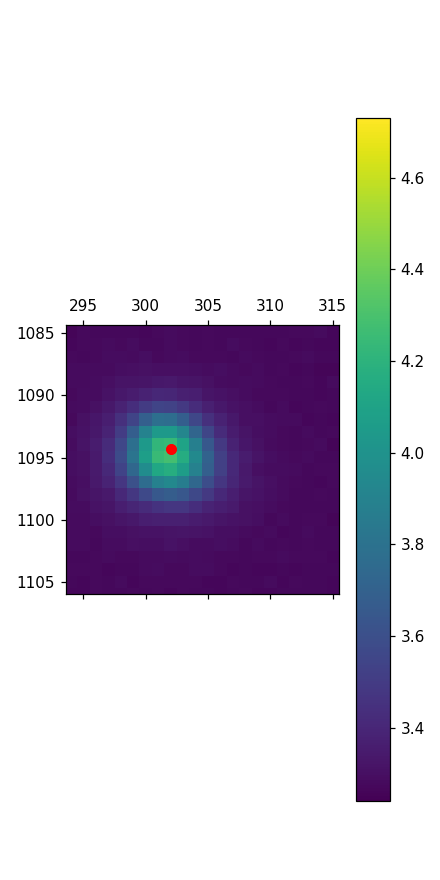

In [31]:
# Display the catalog objects.
bright_rows = catalog_df['decam_flux5'] > 300

plt.matshow(np.log10(image))
plt.colorbar()
pplt.plot(catalog_df[bright_rows]['pix_h'], catalog_df[bright_rows]['pix_w'], 'ro')

In [91]:
# Filter out galaxy pixels.

filter_image = copy.deepcopy(image)
# print [ type.strip() for type in catalog_df['type'] ]
# gal_rows = [ type.strip() == 'PSF' for type in catalog_df['type'] ] 
gal_rows = catalog_df['type'] != 'PSF'

print 'Proportion of objects that are galaxies:'
print np.sum(gal_rows) / float(catalog_df.shape[0])

radius = 8 * catalog_df[gal_rows][['shapeexp_r', 'shapedev_r']]
radius['min_radius'] = 3.0
gal_radius = radius.apply(np.max, 1)

print gal_radius

Proportion of objects that are galaxies:
0.528735632184
1600     3.600000
1610     3.600000
1614    10.502559
1618     3.600000
1622     3.087514
1623     7.372073
1624     3.600000
1625    11.321456
1631     4.763892
1635     3.600000
1636     6.975192
1642     4.380355
1643     3.600000
1647    10.633224
1648     3.600000
1650     3.600000
1653     3.600000
1658     8.326407
1660     3.600000
1666     3.600000
1667     3.000000
1668     3.600000
1669     7.558437
1683     6.150900
1684    11.060490
1686     3.600000
1687     3.600000
1691     3.600000
1696     3.600000
1698    18.645428
          ...    
270      3.600000
271      3.600000
272      3.600000
274      3.600000
278      7.523314
279      3.600000
280      3.600000
281      3.600000
289      3.600000
290      3.600000
291     13.160077
292     12.031034
295      3.600000
299     44.761642
302      3.600000
311      3.600000
315      3.600000
316      3.600000
323      3.600000
327      3.600000
328      3.600000
334     